In [1]:
# tensorflow 경고 메세지 무시
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# clear_output()을 통해 print 했던 로그들을 지우고 새로 출력하게 함
from IPython.display import clear_output 

# InteractiveShell 옵션에 'all'을 주면 주피터 노트북의 각 셀에서 가장 마지막 줄 뿐만 아니라, 출력하도록 한 모든 값이 출력됨
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

# 높은 이미지 해상도
%config InlineBackend.figure_formats = {'png','retina'}

# pandas 데이터프레임이 너무 긴 경우 가로, 세로 몇 줄까지 보여줄 것인지 설정
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [3]:
# Matplotlib을 시각화 모듈로 사용하지만, plot의 기본 스타일은 seaborn의 스타일을 따르도록 한다
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

# 데이터 불러오기 및 라벨링

In [5]:
import glob
from pathlib import Path
   

def getImageFromPath(path):
    '''
    폴더 경로를 입력하면 그 폴더 내부의 분류된 폴더와 이미지를 라벨링하여 반환
    
    실행예시
    path = './data/train/'
    x_dir_ls, img_file, y_list = getImageFromPath(path)
    '''
    x_dir_ls = [] # 각 이미지 경로 리스트
    img_file = [] # 이미지 파일 명 리스트
    y_list = [] # y값 리스트
    # count = 0
    
    basepath = Path(path)
    for entry in basepath.iterdir():
        dir2 = os.path.join(path, entry.name)
        filenames = os.listdir(dir2)
        for filename in filenames:
            x_dir_ls.append(os.path.join(dir2, filename))
            img_file.append(filename)
            y_list.append(entry.name)

#     folders = glob.glob(path + '/*')
#     for folder in folders:
#         for fname in glob.glob(folder + '/*'):
#             full_fname = fname
#             x_dir_ls.append(full_fname)
#             img_file.append(fname.split('/')[-1])
#             y_list.append(folder.split('/')[-1]) # 웹툰 작가를 y값인 라벨로 설정함 
    print("All image path listing complete!")
    
    return x_dir_ls, img_file, y_list # 각 이미지들의 경로, 이미지 파일명, y값 리스트 

In [6]:
path = './data/imgs_all/'
x_dir_ls, img_file, y_list = getImageFromPath(path)
print("카테고리 갯수, x_dir갯수, img_file 갯수 : ", len(set(y_list)), len(x_dir_ls), len(img_file))

All image path listing complete!
카테고리 갯수, x_dir갯수, img_file 갯수 :  2596 343151 343151


In [7]:
x_dir_ls[0]

'./data/imgs_all/용용/샬롯에게는 다섯 명의 제자가 있다30화.jpg'

# 데이터 전처리(이미지 크기 조절)

In [8]:
from PIL import Image as pil

# 이미지 numpy 배열화
def imageToNpArray(img_path_ls, w, h, img_mode="RGB"): 
    '''
    img_path_ls : 각 이미지의 full path
    w, h : 변경할 사이즈 가로, 세로
    img_mode : 기본값 "RGB", https://pillow.readthedocs.io/en/stable/handbook/concepts.html
    
    이미지를 불러와 w x h 크기로 리사이징
    CNN 학습에 맞게 0~1 사이로 맞춰주기 위하여 255로 나눠주는 함수
    '''
    
    X_RGBimgs = []
    print("image to numpy array & image resizing on process")

    for i in range(0, len(img_path_ls)):
        # resize로 이미지 크기를 축소시켜서 사용 (메모리 제한 및 이미지 크기 통일)
        img_resize = pil.open(img_path_ls[i]).resize((w,h), pil.ANTIALIAS).convert(mode=img_mode)
        img_unit8 = np.asarray(img_resize, dtype='uint8')
        X_RGBimgs.append(img_unit8)
        if i % 150 == 0:
            # \r : 다음 출력시 맨 앞으로 (덮어쓰기)
            print(i,"/",len(img_path_ls)," ==> ",y_list[i], img_path_ls[i], img_unit8.shape, "completed", end='\r')
    plt.figure(figsize=(5,5))
    plt.imshow(img_resize)
    plt.title("마지막으로 처리한 이미지 : " + img_path_ls[i].split('/')[-1].split('.')[0])
    clear_output()
    plt.show()
 
    X_raw = np.asarray(X_RGBimgs)
    X_raw = X_raw.astype('float32')/255.0         
    
    print("image processing complete!",w,"*",h,"--")
    print("마지막으로 처리한 이미지")
    print(X_raw.shape, X_raw.dtype)
    
    return  X_raw

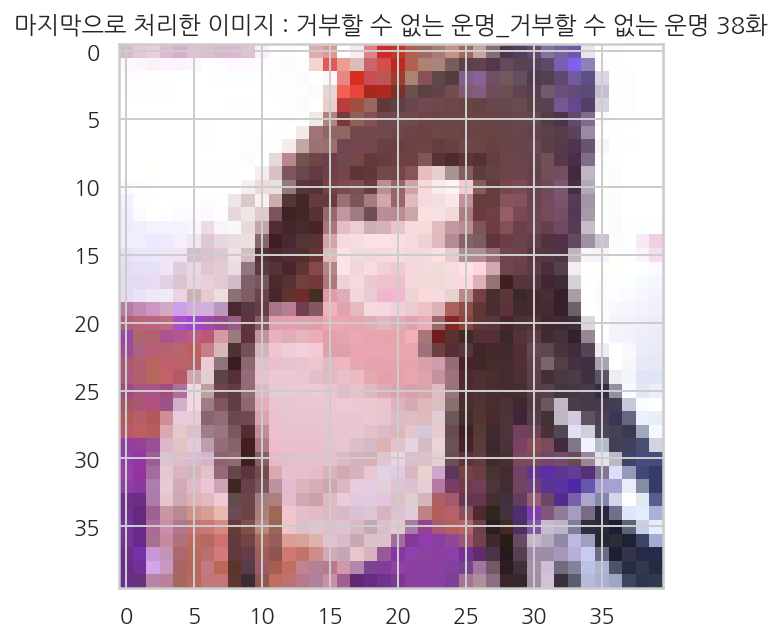

image processing complete! 40 * 40 --
마지막으로 처리한 이미지
(343151, 40, 40, 3) float32


343151

In [9]:
# 이미지 path 리스트, 가로px, 세로px, 이미지 모드

X_raw = imageToNpArray(x_dir_ls, 40, 40)
np.save('./models/350_1_40_40', X_raw)
len(X_raw)

In [9]:
# X_raw = np.load('./models/350_1_40_40.npy')
# len(X_raw)

In [10]:
import sys

def print_size(size):
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'K', 2: 'M', 3: 'G', 4: 'T'}
    while size > power:
        size /= power
        n += 1
    print(f'{size:.2f} {power_labels[n]}B')

print_size(sys.getsizeof(X_raw))

6.14 GB


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y_list)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=0)

# Encoder

In [13]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [14]:
encoder_input = Input(shape=(40, 40, 3))

# 40 X 40
x = Conv2D(32, 3, padding='same')(encoder_input) 
x = BatchNormalization()(x)
x = LeakyReLU()(x) 

# 40 X 40 -> 20 X 20
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x) 
x = LeakyReLU()(x) 

# 20 X 20 -> 10 X 10
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 10 X 10
x = Conv2D(256, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

encoder_output = Dense(400)(x)

In [15]:
encoder = Model(encoder_input, encoder_output)

In [16]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 20, 64)        0     

# Decoder

In [17]:
decoder_input = Input(shape=(400, ))

# 2D 좌표를 10*10*64 개의 neuron 출력 값을 가지도록 변경합니다.
x = Dense(10*10*256)(decoder_input)
x = Reshape( (10, 10, 256))(x)

# 10 X 10 -> 10 X 10
x = Conv2DTranspose(256, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 10 X 10 -> 20 X 20
x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 20 X 20 -> 40 X 40
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 40 X 40 -> 40 X 40
x = Conv2DTranspose(32, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 최종 output
decoder_output = Conv2DTranspose(3, 3, strides=1, padding='same', activation='tanh')(x)

In [18]:
decoder = Model(decoder_input, decoder_output)

In [19]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 25600)             10265600  
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 256)       590080    
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 10, 256)       1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       2950

In [20]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 1024

In [21]:
encoder_in = Input(shape=(40, 40, 3))
x = encoder(encoder_in)
decoder_out = decoder(x)

# Auto Encoder 모델을 최종 정의

In [22]:
auto_encoder = Model(encoder_in, decoder_out)

In [23]:
auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=tf.keras.losses.MeanSquaredError())

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

checkpoint_path = './models/autoencoder_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             monitor='val_loss', 
                             verbose=1)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=10)

In [25]:
hist = auto_encoder.fit(X_train, X_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=100, 
                        callbacks=[checkpoint, es], 
                        validation_data=(X_test, X_test))

Epoch 1/100
269/269 [==============================] - 234s 843ms/step - loss: 0.1230 - val_loss: 0.0648

Epoch 00001: val_loss improved from inf to 0.06482, saving model to ./models/autoencoder_checkpoint.h5
Epoch 2/100
269/269 [==============================] - 224s 834ms/step - loss: 0.0216 - val_loss: 0.0271

Epoch 00002: val_loss improved from 0.06482 to 0.02709, saving model to ./models/autoencoder_checkpoint.h5
Epoch 3/100
269/269 [==============================] - 224s 834ms/step - loss: 0.0142 - val_loss: 0.0123

Epoch 00003: val_loss improved from 0.02709 to 0.01227, saving model to ./models/autoencoder_checkpoint.h5
Epoch 4/100
269/269 [==============================] - 224s 834ms/step - loss: 0.0107 - val_loss: 0.0103

Epoch 00004: val_loss improved from 0.01227 to 0.01025, saving model to ./models/autoencoder_checkpoint.h5
Epoch 5/100
269/269 [==============================] - 224s 835ms/step - loss: 0.0091 - val_loss: 0.0084

Epoch 00005: val_loss improved from 0.01025 to

# 학습 결과

Text(0.5, 1.0, 'Training and Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

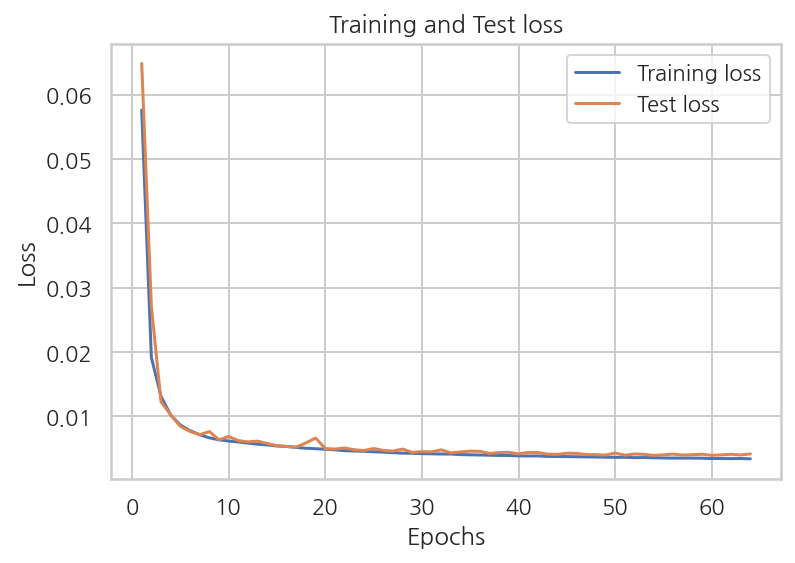

In [27]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs=range(1, 64+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Training and Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

(0.0, 0.01)

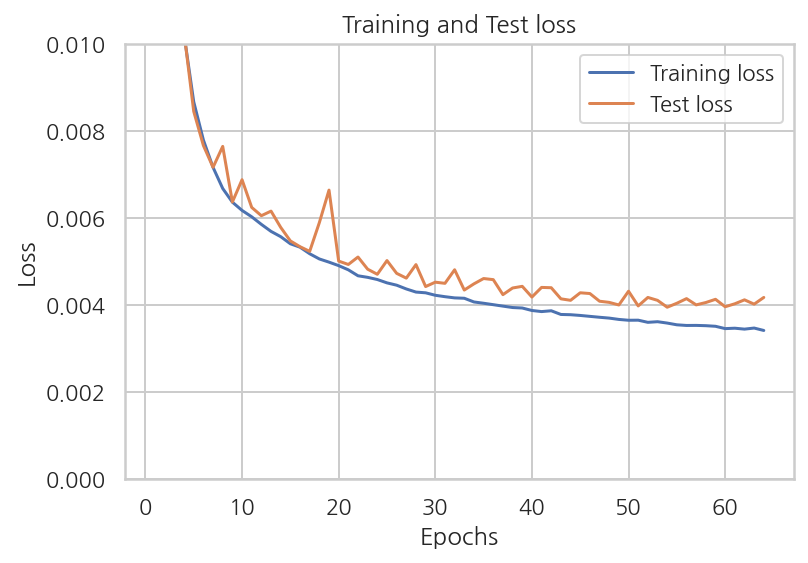

In [28]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs=range(1, 64+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.01)
plt.legend()

plt.show()

In [29]:
auto_encoder.load_weights(checkpoint_path)

In [30]:
encoder.save('./models/encoder.h5')

# 오토인코더 결과 시각화

In [31]:
decoded_images = auto_encoder.predict(X_test)

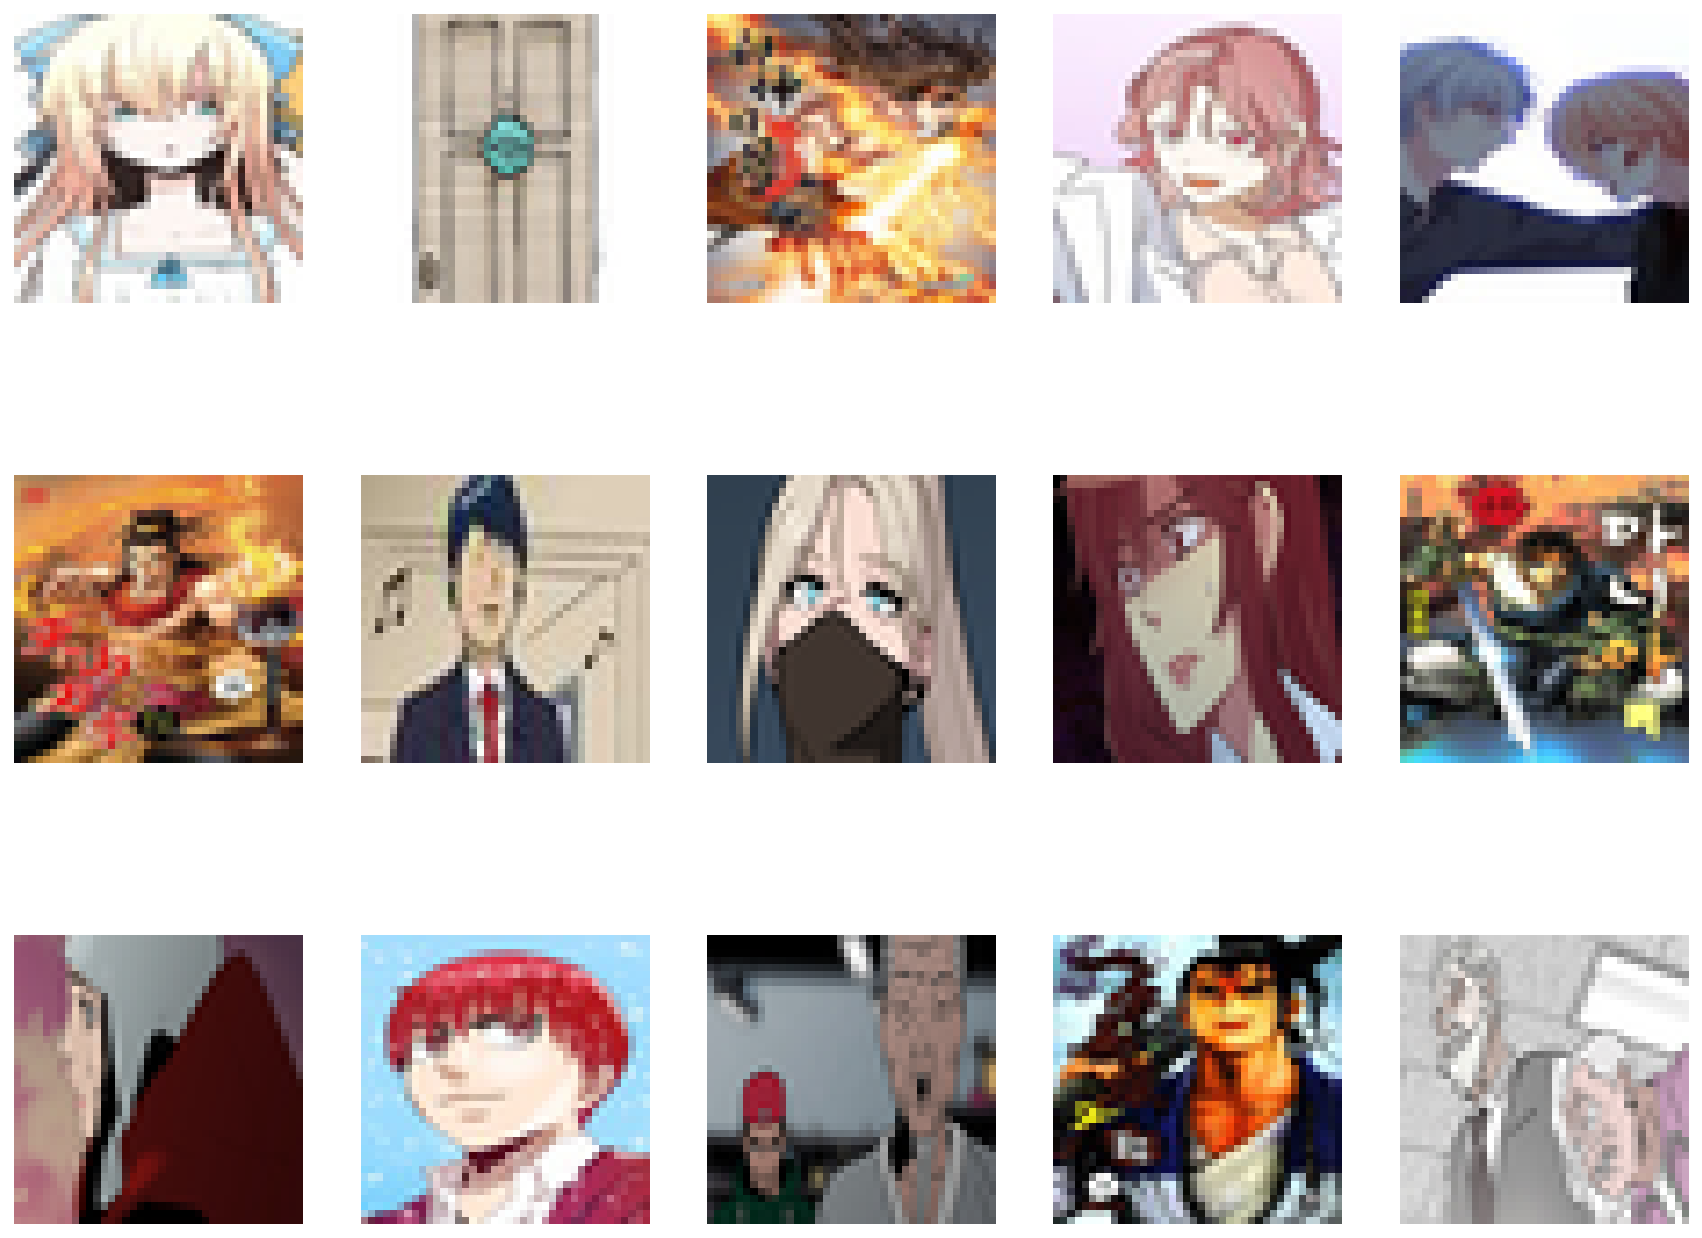

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


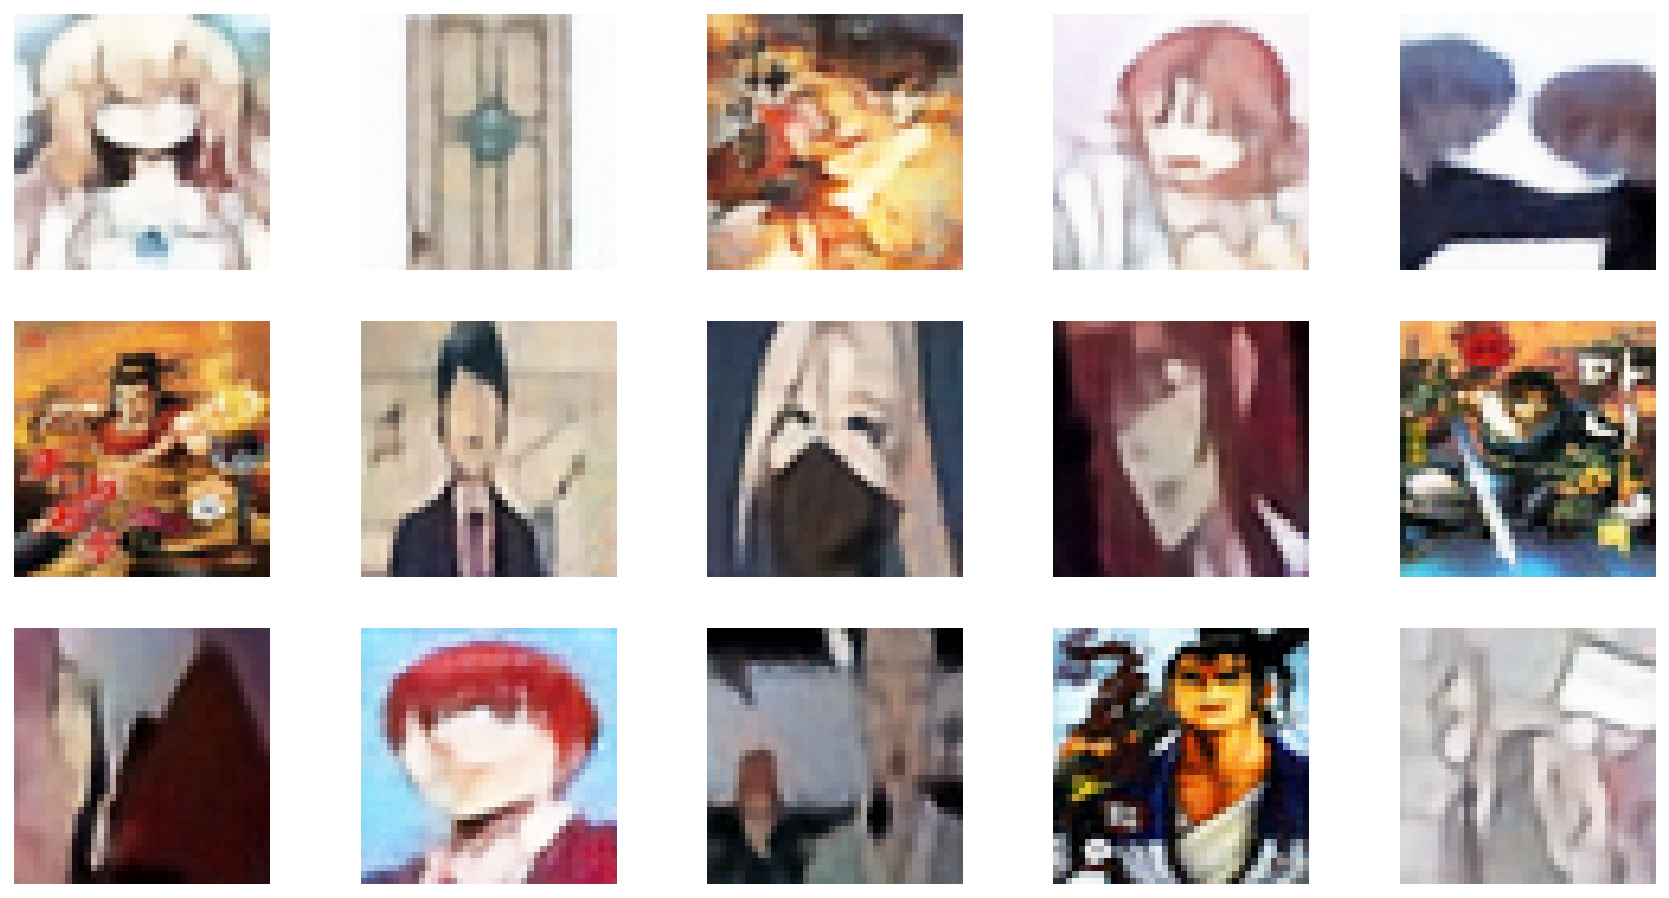

In [32]:
plt.figure(figsize=(15, 12));
for i in range(15):
    plt.subplot(3, 5, i+1);
    plt.imshow(X_test[i+15]);
    plt.axis('off');
plt.show();

plt.figure(figsize=(15, 8))
for i in range(15):
    plt.subplot(3, 5, i+1);
    plt.imshow(decoded_images[i+15]);
    plt.axis('off');
plt.show();

# Latent Vector 이미지 유사도 결과

In [33]:
xy = encoder.predict(X_test)

In [34]:
xy.shape

(68631, 400)

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

cs = cosine_similarity(xy, xy)

In [36]:
csdf = pd.DataFrame(cs)

In [37]:
xy_label = le.inverse_transform(y_test)

In [38]:
def plot_similar_wbt(find_index, csdf, X, y):
    '''
    find_index : 찾을 인덱스 (순서)
    result_df : 행은 이미지 데이터, 열은 각 웹툰일 확률
    X : 원본 이미지 데이터 리스트
    '''
    
    # 확인할 이미지 데이터
    img = X[find_index]
    
    # 확인할 이미지 데이터의 레이블(작가)
    real_file_name = y[find_index]
    
    # 확인할 이미지 출력
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.grid(False)
    plt.title(real_file_name, fontsize='medium')
    plt.xticks([])
    plt.yticks([])
    
    
    # top10 이미지 출력
    plt.figure(figsize=(15, 8))
    top10s = csdf[find_index].sort_values(ascending=False)[1:11].index
    sims = csdf[find_index].sort_values(ascending=False)[1:11].values
    i = 0
    for idx in top10s:
        plt.subplot(2, 5, i+1)
        plt.imshow(X[idx])
        plt.grid(False)
        plt.title(str(y[idx]) + '\n' + str(sims[i]), fontsize='medium')
        plt.xticks([])
        plt.yticks([])
        i += 1

    plt.show()

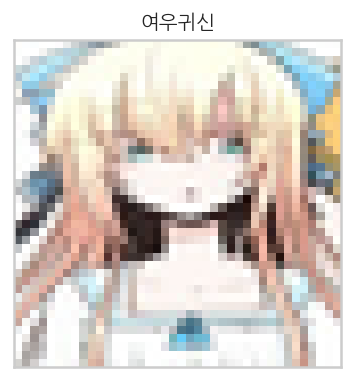

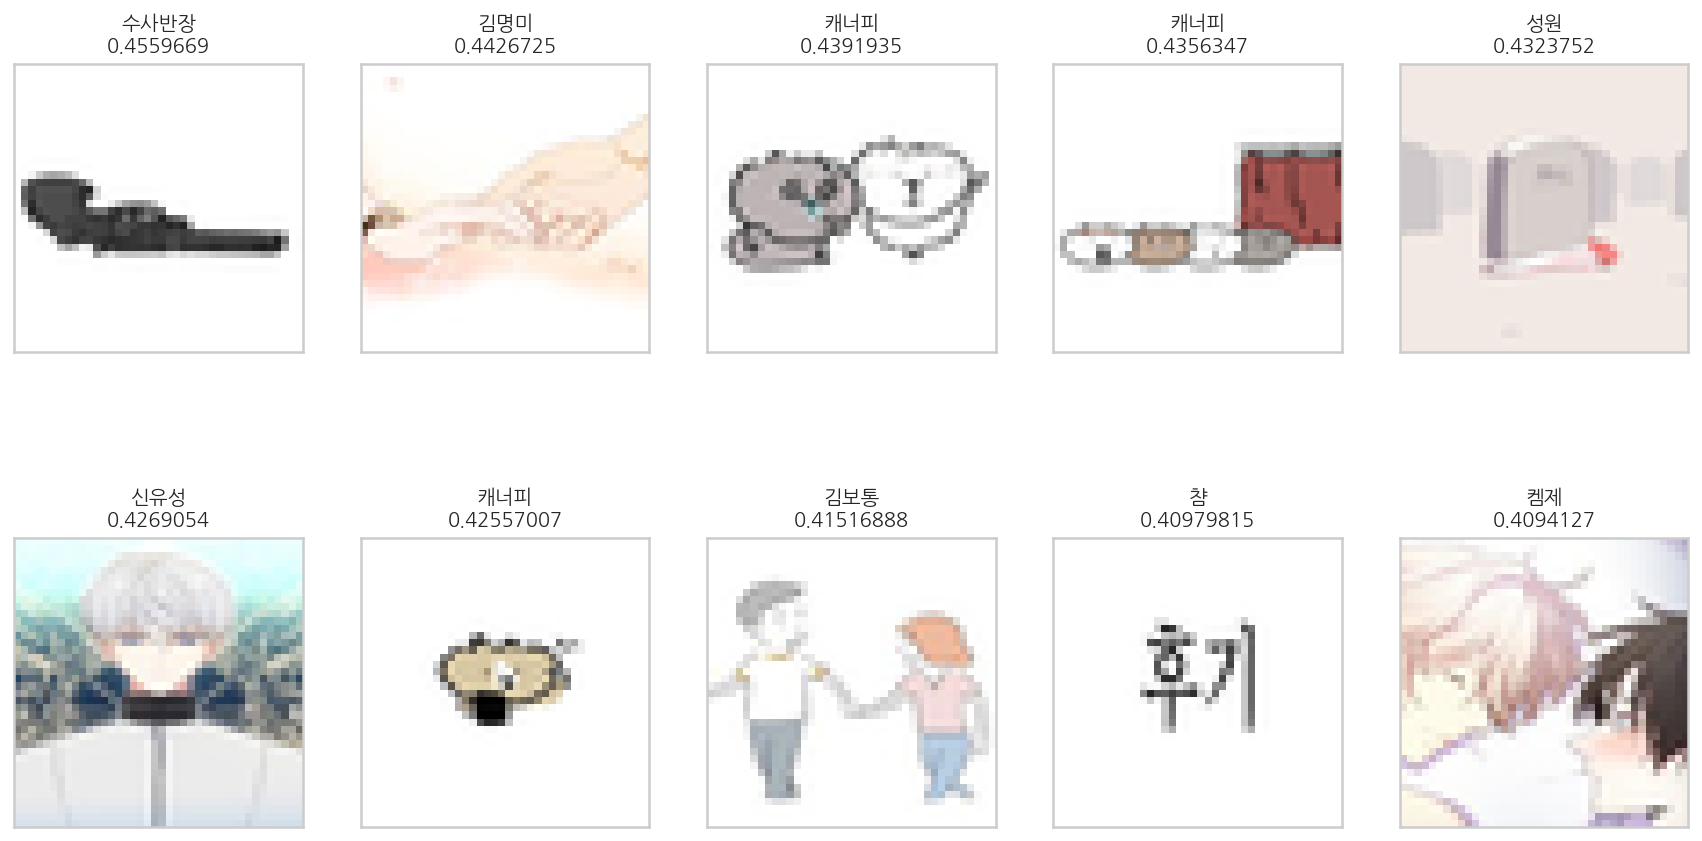

In [39]:
plot_similar_wbt(15, csdf, X_test, xy_label)

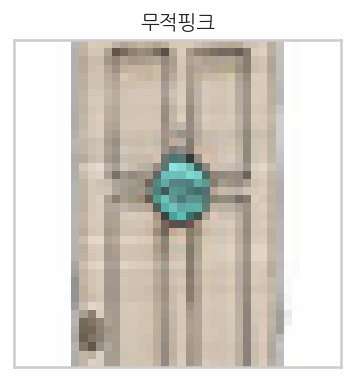

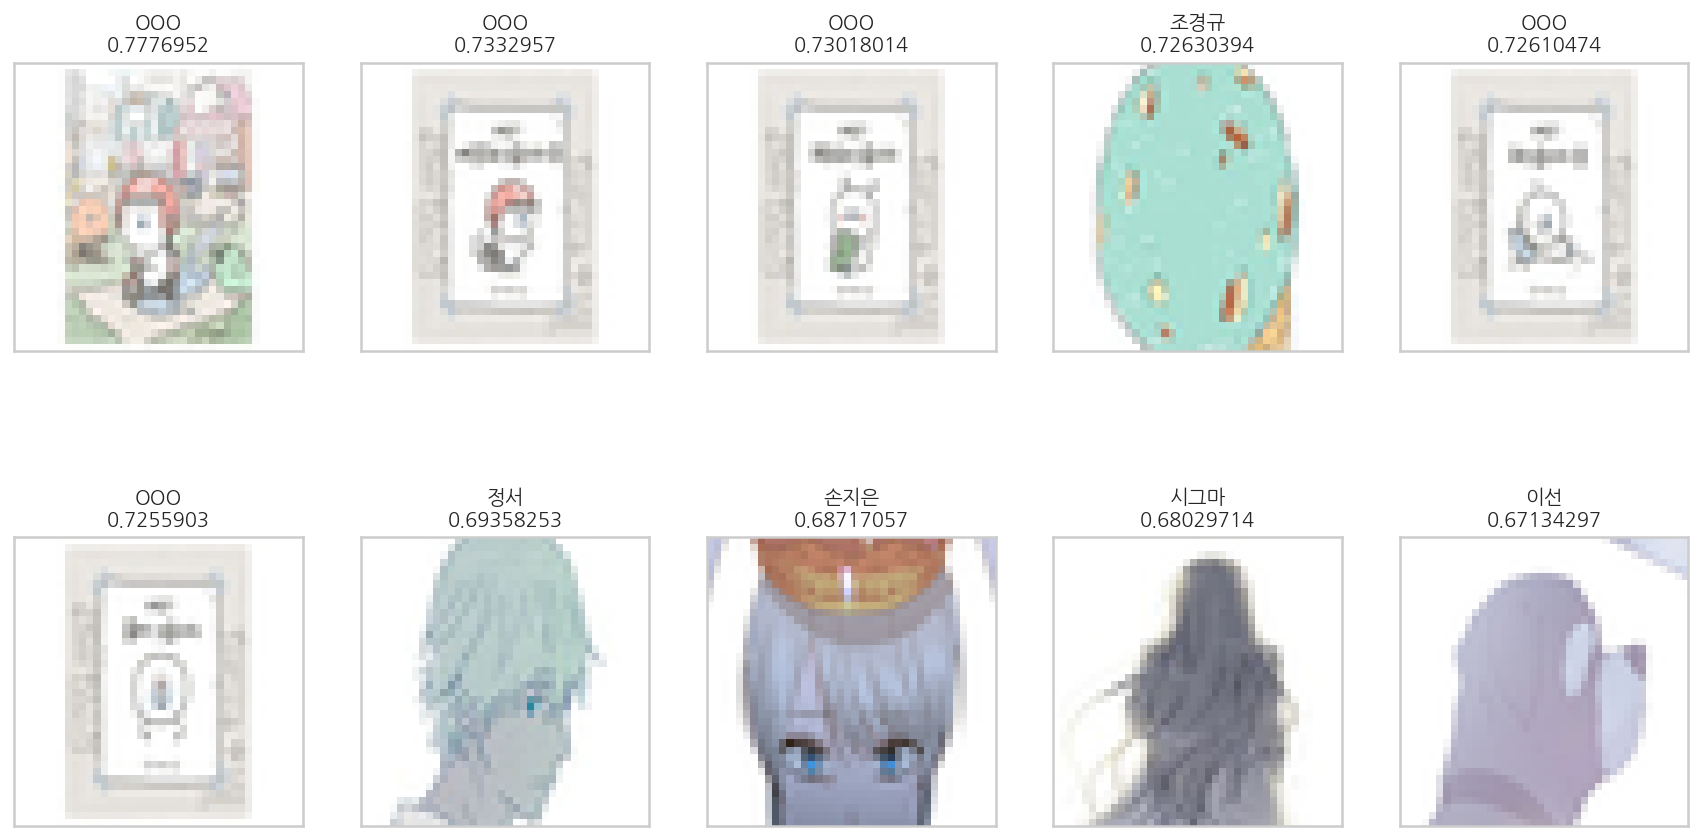

In [40]:
plot_similar_wbt(16, csdf, X_test, xy_label)

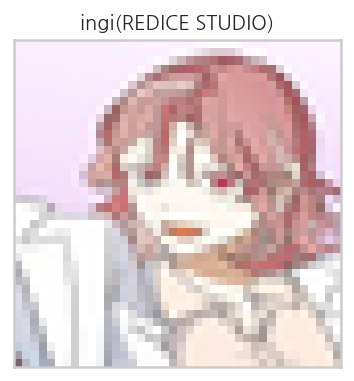

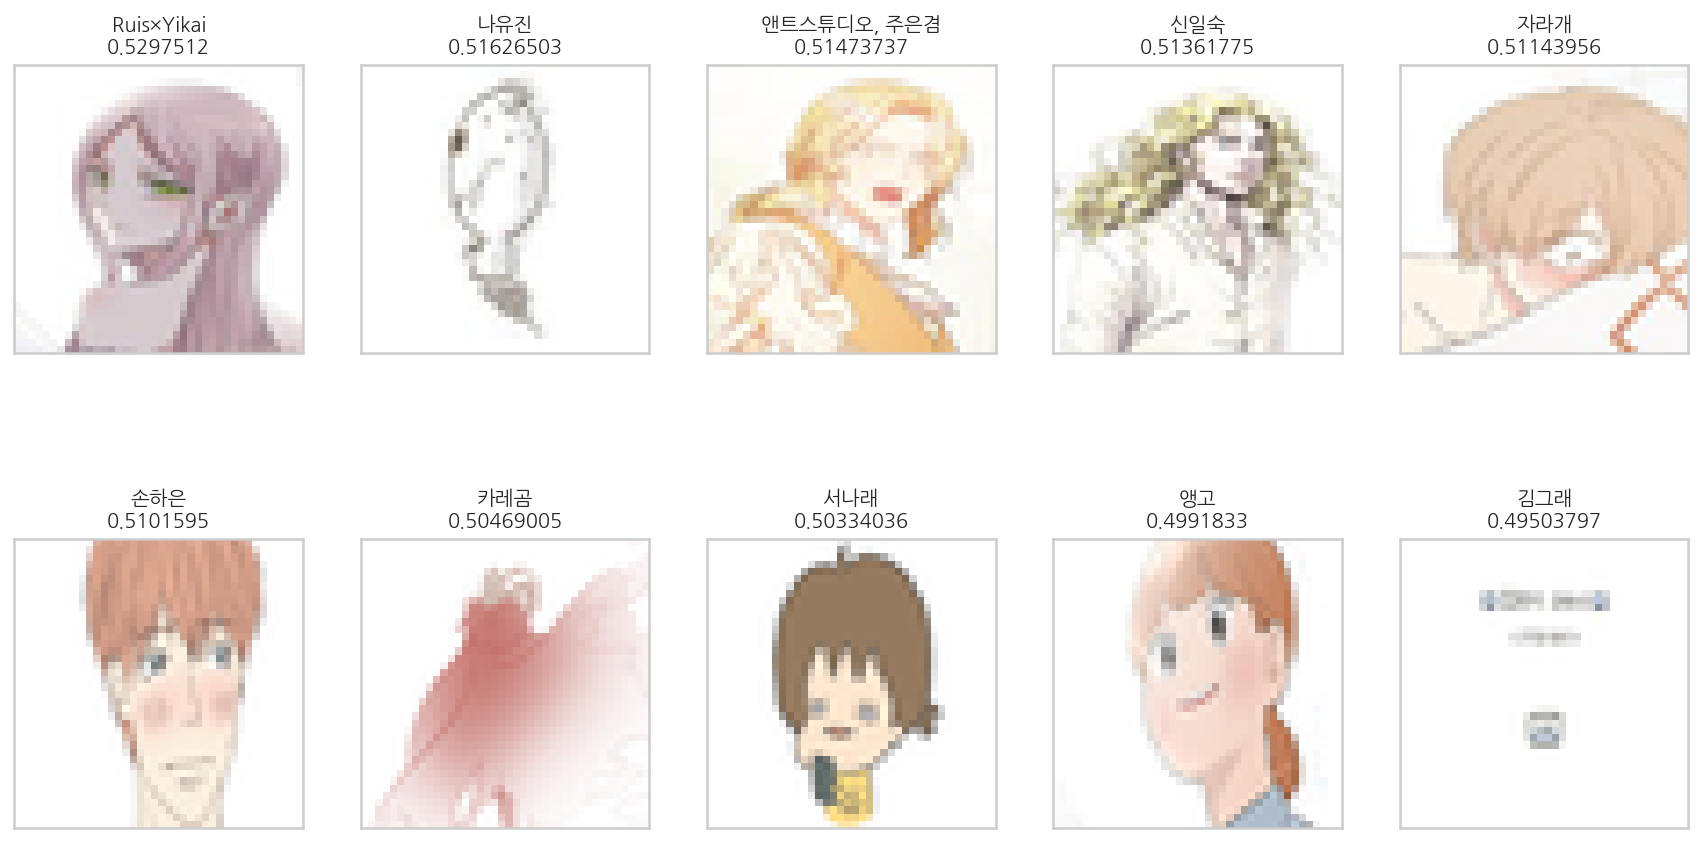

In [42]:
plot_similar_wbt(18, csdf, X_test, xy_label)

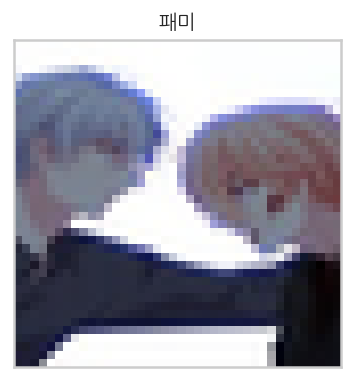

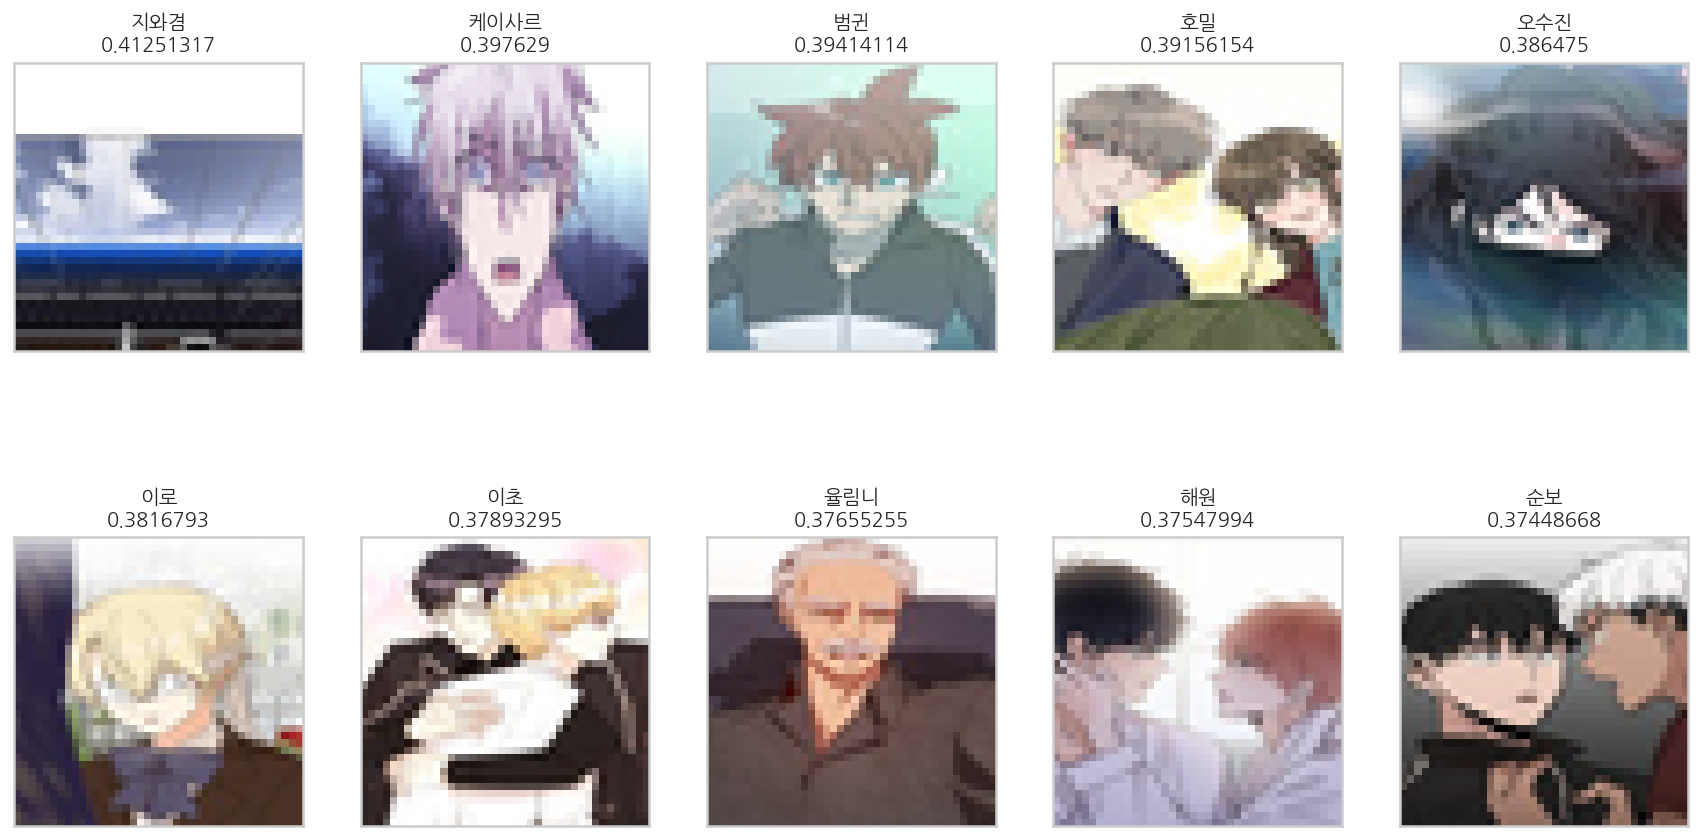

In [43]:
plot_similar_wbt(19, csdf, X_test, xy_label)

# Latent Vector를 작가별로 평균을 내어 시각화

In [44]:
xy_df = pd.DataFrame(xy, index=xy_label)

In [45]:
xy_df.reset_index().groupby('index').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-2℃,3.454178,-1.949516,-1.369790,-0.379602,-0.149935,1.372768,-1.443305,2.201469,1.982944,0.342225,-1.831882,-0.245322,-0.282889,0.363072,-1.412825,1.450003,-2.058891,-6.450033,-2.100244,0.123547,-0.921612,-0.297001,1.990236,-6.119235,25.974375,1.044578,0.316364,-2.142310,-0.217730,0.113240,-2.728112,-2.855495,1.267175,1.479319,-1.718194,-1.347957,-3.954370,1.083445,2.163200,1.550958,4.273294,-0.602937,0.888834,1.681580,-1.142051,1.993793,0.774779,1.396983,4.211743,-0.280949,0.170456,-1.715319,-2.299443,0.613436,0.601634,-0.567614,-1.013234,-1.123406,0.006759,2.649282,-0.873199,-0.146629,-4.539062,0.570802,8.493133,-5.846015,1.779502,2.492429,-1.931868,2.328382,-3.449507,0.126866,-0.480304,-0.170585,-4.881794,-5.298499,-0.983101,0.582433,-1.434567,1.272228,-2.738457,-2.635946,-1.394170,1.117819,1.343357,-0.559621,-1.297940,0.102489,1.561544,1.650396,-1.170855,1.384501,-0.576869,1.542237,-1.368814,-3.547789,-3.169243,0.238806,-10.987954,-1.722417,...,-0.752694,-2.632606,1.603854,-0.987186,0.685802,1.141290,0.619704,4.043215,-1.279480,-5.155680,2.432345,4.387004,0.411650,-0.889614,-3.971599,-2.553198,-5.454884,0.848933,2.082168,-15.444574,-4.050331,0.139455,-1.899183,0.917507,-2.557365,-1.732042,-3.038029,1.280038,2.623718,3.066972,-0.318857,0.164343,-1.425406,1.253889,1.758462,-3.258760,-0.899869,-5.113151,-3.785141,0.426864,0.788906,-0.512848,-0.459384,-2.995039,-1.072362,-1.705618,4.184440,0.057140,-0.633056,0.279351,3.562659,5.177760,-1.729700,-0.528602,-2.450451,0.760585,5.730376,0.807729,-2.946667,-3.543550,0.683837,0.662345,-2.127301,1.859405,1.376187,-2.042995,-1.002000,3.150842,2.330649,-0.097725,-1.168500,-0.339029,0.668311,-0.664386,-1.267439,-0.022575,8.031361,-1.166479,2.347695,2.985289,1.210378,0.409105,-2.451903,-3.111763,-1.489544,-1.004707,-0.977982,-4.032169,-0.125023,4.085975,2.374519,0.861158,-0.406363,-5.474836,0.142093,1.844198,-6.128619,3.213586,-1.164007,-3.494731
12B,2.775765,-4.769994,-0.493214,5.552860,1.103647,2.528620,2.693197,0.423783,3.865494,1.151127,-2.075313,-6.402294,-4.235734,-1.795870,3.582810,-0.482212,3.227144,-6.382582,4.366597,-0.499524,-3.209790,0.651032,1.913719,5.475461,-22.993301,-1.767037,2.782241,8.731753,4.025442,0.944776,1.486535,-5.269895,1.067486,-2.172769,3.009294,4.019137,-0.950278,0.870177,-6.055551,0.857542,0.566017,-3.050343,-2.138369,1.690471,6.415991,2.538014,-1.420020,-3.877011,-3.650315,4.976958,10.867406,-5.662349,7.570391,-0.933593,-3.628135,-1.839595,8.730556,-0.797862,2.672427,-4.431624,-2.116569,0.278412,1.106373,-1.152925,-6.087683,6.332374,1.292532,-0.005785,-3.876868,5.538796,-2.796367,2.355493,3.895630,1.077578,2.321518,1.100478,1.875992,0.437822,3.273361,-3.501606,4.539539,-2.880120,1.202715,0.196736,-2.653540,-5.954387,6.690887,-0.824194,-1.234773,-0.077341,-4.472165,5.049632,-4.334904,-0.537064,-3.598642,-6.680580,4.298262,2.128814,16.349518,-0.376048,...,-10.851858,5.577209,-2.403803,-3.519964,-3.857196,3.739947,5.464941,-2.485755,-2.858216,-12.538611,-9.150284,5.958254,1.107147,-5.951890,1.688742,0.085881,-5.026320,-3.105405,-7.533815,-3.438391,4.786300,6.651039,-3.300408

In [46]:
vs = xy_df.reset_index().groupby('index').mean().values

In [47]:
cs2 = cosine_similarity(vs, vs)

In [48]:
csdf2 = pd.DataFrame(cs2, index=xy_df.reset_index().groupby('index').mean().index, columns=xy_df.reset_index().groupby('index').mean().index)

In [49]:
csdf2

index,-2℃,12B,149,17지성,209,232,247,2631,2B,2사장,2오,35,38,5후,60,89line,911,9P,A YANG,A-soul HAN CHAO,A4 STUDIO,A4스튜디오,AG,AJS,ALIC,ARI,ASK studio,ASURA,Akimine Kamijyo,Amateurs R&S,Asoul·고리불키,Asoul·풀주먹밥,Asoul•RIGON,At.Kenny,Aweiwei,Awin,Axis,BARZ Jr,BOE COMICS,BOE COMMIC,BOHA,BV,BaeDA,Bajiaoding Binggan,Bill K,Blacksad검은고양이,Blue Moon,BoarKnight,Boaz&Deerchaser,Bochuanjiujiuzi,Boyi Animation,CAT-HANDS,CHARA,CHIMA,CHYA,CQ,CTK,Cacti,Canaria,CreativeSUMM,Croissant,Cyber Cat,D JUN,DAMA,DEY,DIAN,DL.Sir,DO.D,DXD Animation,DanBrave,Day7 EVY,Dongmantang,Dr.대길,"Dr.대길, Bart.D",Dragon Culture,Dramatic Frames,ERA CARTOON,FUJISAKI Ryu,Fat수(A-SOUL),FenRenDongMan,"Forget, Phxjoy",Fujimomo,FuyuKi23,Fuyumi Souryo,GIMS,GRAVITY STUDIO,GUAZI,Gido Amagakure,H2O,HAMPIG,HARU,HD3,HI,HO9,HON,HOONNAK,HOOPA,HOSAN,HOSONO Fujihiko,HOUSAILEI,...,현욱,혜,혜니,혜원,혜진양,호골,호돌,호띠,호랑,호밀,호박마차,호산,호연,호욤,호우,호이,호정,호진,호카조노 마사야,호패,혹등고래,혼,홍가,홍기우,홍길동,홍끼,홍다,홍달,"홍반장, 김강원, 디윙",홍비치라,홍상기,홍솔민,홍순식,홍슬,홍예,홍원표,홍일,홍작가,홍주,홍준기,홍치,홍타래,홍태림,홍필,홍핏,화과,화람,화솜,화음,화정,화화,환댕,환쟁이,활기,활성곰,황동,황미나,황미리,황비노,황성,황양,황영찬,황인빈,황재,황정훈,황준호,황지성,황진영,황짠느,황혜진,효기,효미,효정,후던잇,후드새,후새뢰,후은,후지사키 모에,후지시마 코스케,후지와라 모토요,후지타,후지타 마키,후지타니 요코,휘,휘를,휘요,흑산,희나리,희똑,희명,희세,희열탁마,희원,히가시무라 아키코,히가시자토 키리코,히구리 유우,"히구리 유우, 하마다 쇼코",히눈,히디,힐링달
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-2℃,1.000000,-0.044739,0.435901,0.365124,0.441419,0.363106,-0.090153,-0.053744,0.612874,0.568631,0.085633,-0.050035,0.415332,0.554871,0.553931,0.096344,0.237386,0.258087,0.461110,0.496382,0.448499,0.213231,0.464427,0.440630,-0.058814,0.384940,0.013546,0.119120,0.103742,0.519321,0.223525,0.528871,0.190255,0.172417,0.592934,0.080671,-0.027292,0.207824,0.475187,0.494623,-0.166003,0.663499,-0.196197,0.457369,0.159315,-0.219254,-0.017110,0.046658,0.581832,0.363351,0.322371,0.519790,0.533270,0.338524,0.141960,0.551083,0.229741,0.602698,0.284745,0.250785,0.393631,0.130589,0.505637,0.265028,0.154141,0.251848,0.236191,0.106655,0.358827,0.496656,0.299527,0.213640,0.395847,0.489680,0.315228,0.002112,0.410971,-0.219091,0.395247,0.140804,0.221970,0.561583,-0.026455,-0.197142,0.355116,0.398008,0.154152,0.375094,0.040159,0.246385,0.057335,0.198884,0.450791,0.414643,0.456344,0.615720,-0.029534,0.555954,-0.220621,0.441951,...,-0.320126,0.059555,0.545934,0.236670,0.386604,0.505243,0.371141,0.272886,0.074952,0.423895,0.185308,0.206615,0.637688,-0.363272,0.602690,0.230430,0.480919,0.009372,0.181498,-0.013156,0.420577,-0.296547,0.323992,0.420520,0.157309,0.531145,0.424371,0.336597,-0.254351,0.384838,0.161238,0.237336,-0.249583,0.207061,0.366354,0.228504,-0.400598,-0.325452,0.321247,-0.286730,0.286345,0.278425,0.398466,-0.389932,-0.116988,-0.026934,-0.086997,0.199828,0.360755,0.210566,0.495274,0.110750,0.213340,0.177816,-0.117570,0.291451,0.403720,0.590922,0.297082,-0.350276,-0.164109,-0.281675,-0.363339,-0.296838,0.254894,0.014445,0.431518,-0.211798,0.614602,0.167495,0.238291,0.433666,0.417426,0.062091,0.372688,0.395960,0.161132,0.478434,0.099965,0.575367,0.603552,-0.086312,0.511061,0.214177,0.012890,0.529097,-0.101651,0.304271,0.568702,0.353382,0.248242,0.546657,0.537410,0.329685,0.494655,0.563646,0.531848,0.497772,0.104625,0.574740
12B,-0.044739,1.000000,0.056282,-0.028029,0.049625,0.301746,0.242971,0.122861,-0.070953,-0.067781,0.014726,0.251480,0.151666,0.044231,-0.137788,-0.057466,-0.074286,0.103684,-0.223744,-0.201642,0.009309,0.038718,0.114904,-0.047426,0.341566,0.048747,0.095483,0.309042,0.026716,-0.116833,0.029936,-0.063797,0.091540,0.037570,-0.226497,-0.010125,0.194803,0.147219,-0.021756,0.055913,0.305897,-0.027102,0.098040,-0.128513,0.048814,0.353828,0.092855,0.218648,-0.144529,0.098528,0.042423,-0.145164,-0.067090,-0.158293,0.185830,0.022745,0.142340,-0.136669,-0.051969,-0.064895,0.018267,0.147688,-0.061367,0.068355,0.398813,0.091240,0.205033,0.219050,-0.103214,-0.186532,0.005571,0.035467,0.130718,-0.013272,-0.084520,0.170

In [52]:
from tensorflow.keras.preprocessing import image
import re
import random

# 직접 눈으로 비교해주는 함수
def plot_similar_wbt2(illustrator, df=csdf2):
    '''
    illustrator : 찾을 그림 작가 명
    df : 유사도 데이터프레임
    '''
    df = df.copy()
    df = df[illustrator].sort_values(ascending=False)[1:11]
    
    
    # 기존 작가의 이미지 출력 (최대 3개)
    illust = glob.glob('./data/imgs_all/' + illustrator + '/*')
    random.shuffle(illust)
    plt.figure(figsize=(12, 4))
    for i in range(len(illust[:3])):
        plt.subplot(1, 3, i+1)
        img = image.load_img(illust[i])
        plt.imshow(img)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        
        # 타이틀
        title = illust[i].split('/')[-1].split('_')[0]
        title = illustrator + '\n' + title
        plt.title(title)
    plt.show()
    
    similar_illu = df.index
    similarity = df.values
    
    plt.figure(figsize=(15, 8))
    for i, similar in enumerate(similar_illu):
        ill = glob.glob('./data/imgs_all/' + similar + '/*')
        random.shuffle(ill)
        ill = ill[0]
        img = image.load_img(ill)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        # 타이틀
        title = ill.split('/')[-1]
        if '_' in title:
            title = title.split('_')[0]
        else:
            title = re.sub('\d+화', '', title)
        title = re.sub('휴재', '', title)
        title = re.sub('.jpg|.png', '', title)
        title = similar + '\n' + title + '\n' + str(similarity[i])
        plt.title(title)

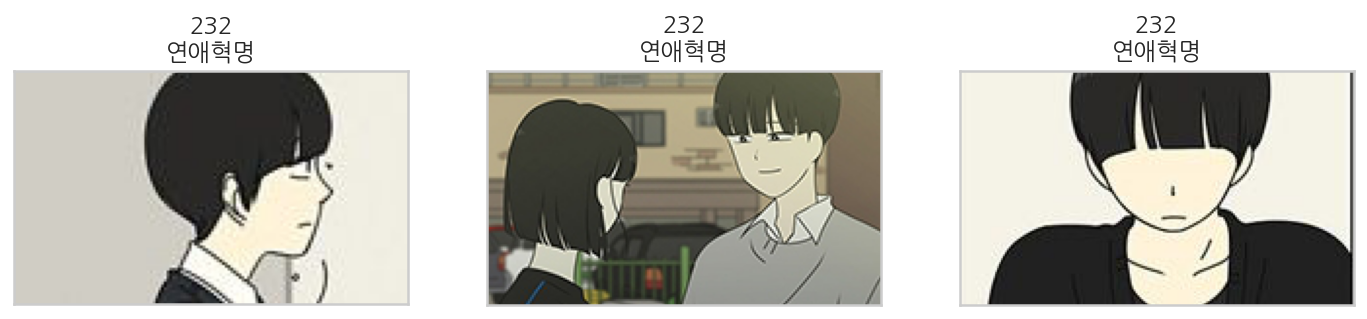

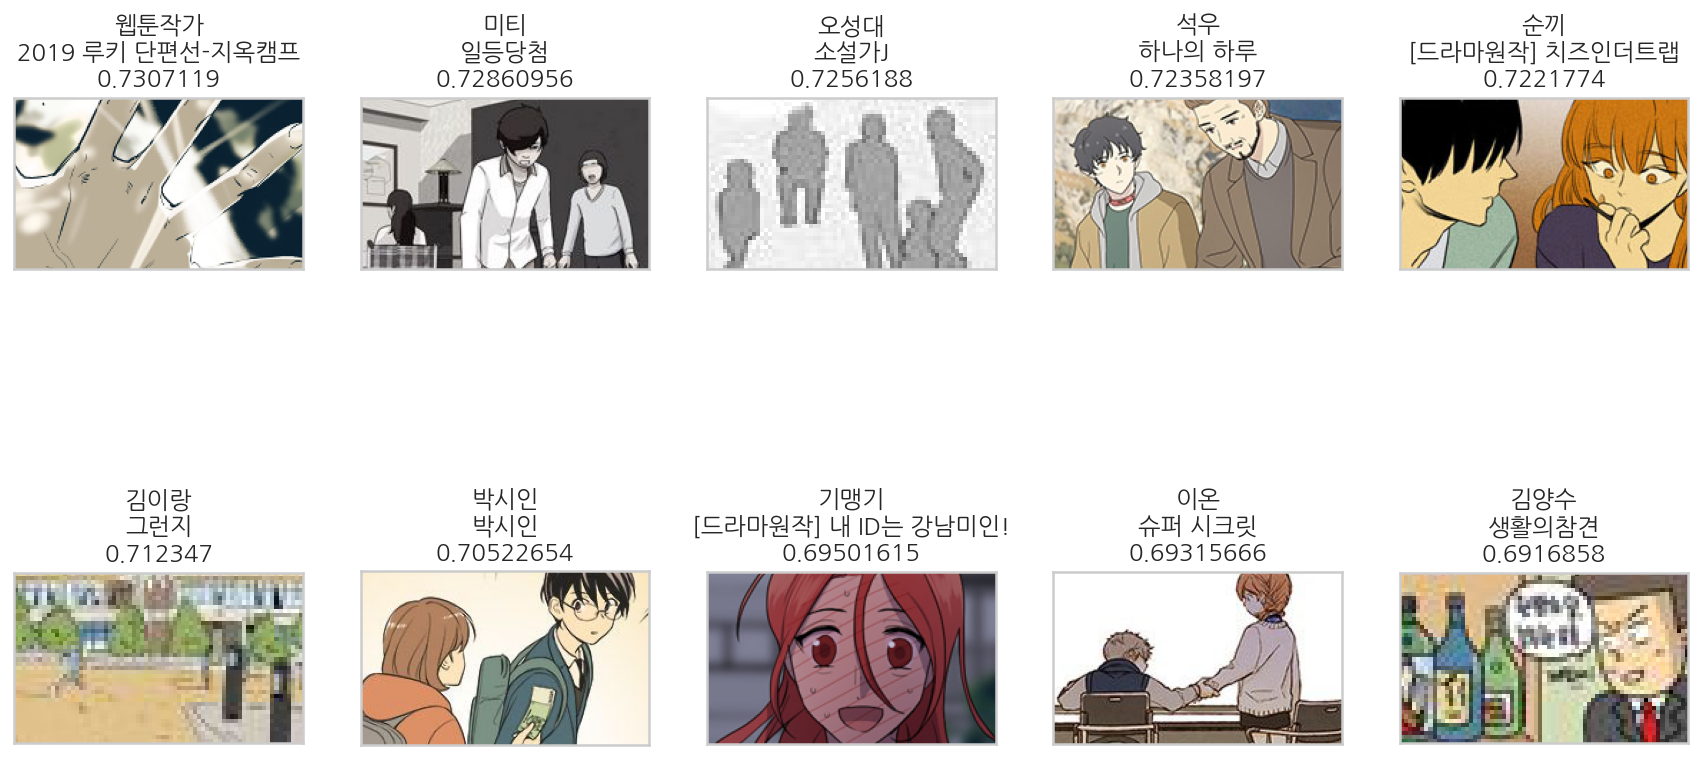

In [53]:
plot_similar_wbt2('232', csdf2)

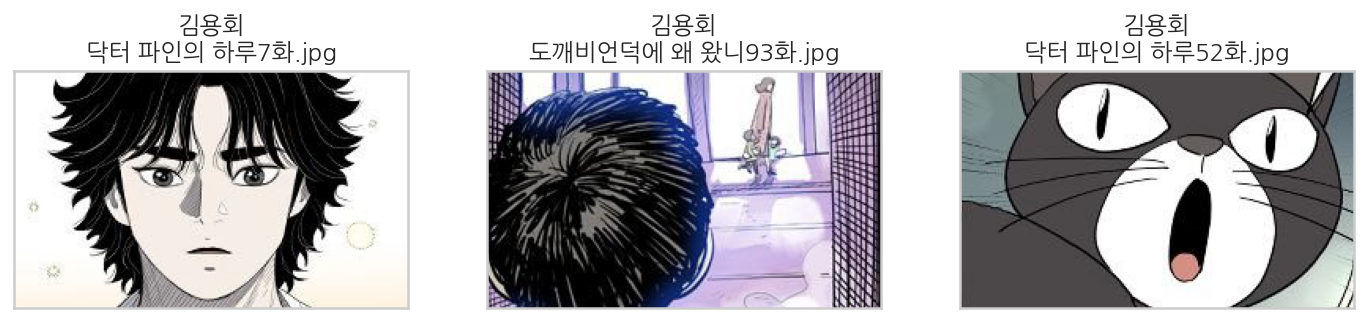

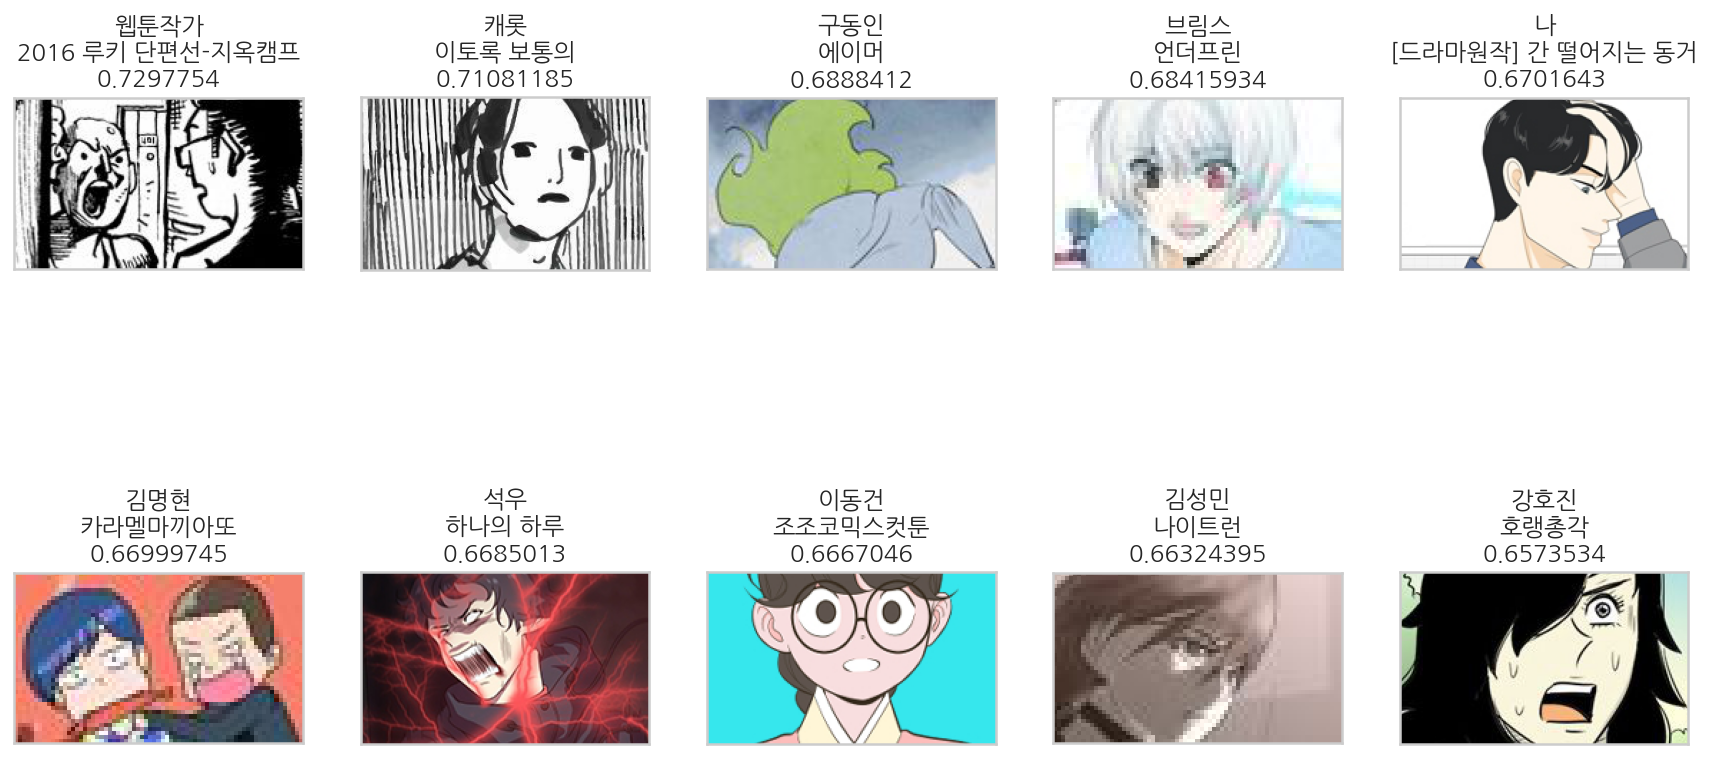

In [54]:
plot_similar_wbt2('김용회')